In [1]:
import numpy as np

import gym
from gym import wrappers

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, Concatenate
from keras.optimizers import Adam

from rl.processors import WhiteningNormalizerProcessor
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

Using TensorFlow backend.
/Users/Aswin_Shriram_T/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/Aswin_Shriram_T/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/Aswin_Shriram_T/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/Aswin_S

In [2]:
from rl import callbacks

In [3]:
class MujocoProcessor(WhiteningNormalizerProcessor):
    def process_action(self, action):
        return np.clip(action, -1., 1.)

In [4]:
ENV_NAME = 'LunarLanderContinuous-v2'

In [5]:
# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
#env = wrappers.Monitor(env, '/tmp/{}'.format(ENV_NAME), force=True)
np.random.seed(124)
env.seed(124)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

/Users/Aswin_Shriram_T/opt/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [6]:
import os

In [7]:
path = os.path.join( os.getcwd(), '..' )
model_save_path = path + '/Model Archive/'
results_save_path = path + '/Results/'

In [8]:
print(path)
print(model_save_path)
print(results_save_path)

/Users/Aswin_Shriram_T/Documents/Northeastern University/Semester 1/Foundations of AI CS5100/Project/Project_Files/FAI Project/DDPG_LLC/Code/..
/Users/Aswin_Shriram_T/Documents/Northeastern University/Semester 1/Foundations of AI CS5100/Project/Project_Files/FAI Project/DDPG_LLC/Code/../Model Archive/
/Users/Aswin_Shriram_T/Documents/Northeastern University/Semester 1/Foundations of AI CS5100/Project/Project_Files/FAI Project/DDPG_LLC/Code/../Results/


In [ ]:
# Next, we build a very simple model.
actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(400))
actor.add(Activation('relu'))
actor.add(Dense(300))
actor.add(Activation('relu'))
actor.add(Dense(200))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('tanh'))
print(actor.summary())

In [ ]:
action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Dense(400)(flattened_observation)
x = Activation('relu')(x)
x = Concatenate()([x, action_input])
x = Dense(300)(x)
x = Activation('relu')(x)
x = Dense(200)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

# Policy Gradient

![Policy Gradient](pg.png)

# Deep Deterministic Policy Gradient (DDPG)

![DDPG](ddpg.png)

In [ ]:
# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=10000000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.1)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=2500, nb_steps_warmup_actor=2500,
                  random_process=random_process, gamma=.99, target_model_update=1e-3,
                  processor=MujocoProcessor())
agent.compile([Adam(lr=1e-4), Adam(lr=1e-3)], metrics=['mae', 'mse'])

In [ ]:
# # Okay, now it's time to learn something! We visualize the training here for show, but this
# # slows down training quite a lot. You can always safely abort the training prematurely using
# # Ctrl + C.
#from keras.callbacks import CSVLogger

In [ ]:
# csv_logger = CSVLogger('ddpg_LLC_v2_log.csv', append=True, separator=';')
# agent.fit(env, nb_steps=100000, visualize=False, callbacks=[csv_logger], verbose=1)

In [ ]:
#history_callback = agent.fit(env, nb_steps=100000, visualize=False, verbose=1)

In [ ]:
#agent.fit(env, nb_steps=1000000, visualize=False, callbacks=[callbacks.FileLogger('ddpg_{}_weights.txt'.format(ENV_NAME))], verbose=2)

In [ ]:
env.close()

In [ ]:
# After training is done, we save the final weights.
#agent.save_weights('ddpg_{}_weights_close.h5f'.format(ENV_NAME), overwrite=True)

In [ ]:
# model_json = agent.model_json()
# with open("agent_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5

In [ ]:
#agent.actor.save('ddpg_actor_model_direct.h5')

In [ ]:
# model_json = agent.actor.to_json()
# with open("ddpg_actor_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# agent.actor.save_weights("ddpg_actor_model.h5")
# print("Saved model to disk")

In [ ]:
# model_json = agent.critic.to_json()
# with open("ddpg_critic_model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# agent.actor.save_weights("ddpg_critic_model.h5")
# print("Saved model to disk")

In [ ]:
# # load json and create model
# json_file = open('ddpg_model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("ddpg_model.h5")
# print("Loaded model from disk")

In [ ]:
agent.load_weights(model_save_path + 'ddpg_{}_weights.h5'.format(ENV_NAME))

In [ ]:
env.close()

In [ ]:
# Finally, evaluate our algorithm for 5 episodes.
agent.test(env, nb_episodes=5, visualize=True)

In [ ]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder

In [ ]:
def video_saver(filename, agent=agent, env=env, num_epi=5, path_save = results_save_path+'Videos/'):
    rec = VideoRecorder(env, path = path_save+filename, enabled=True)
    rec.capture_frame()
    for i_episode in range(num_epi):
        rec.capture_frame()
        observation = env.reset()
        for t in range(1000):
            env.render()
            #print(observation)
            #action = agent.actor.predict(observation.reshape(1,1,env.observation_space.shape[0]))
            action = agent.select_action(observation.reshape(1,env.observation_space.shape[0]))
            #print(action)
            observation, reward, done, info = env.step(action)
            rec.capture_frame()
            if done:
                print("Episode finished after {} timesteps".format(t+1))
                print("Reward at the end of episode {} :".format(i_episode+1), reward)
                break
    rec.close()
    env.close()

In [ ]:
video_saver('ddpg_{}_results_test_2.mp4'.format(ENV_NAME))

In [ ]:
# Finally, evaluate our algorithm for 5 episodes.
history = agent.test(env, nb_episodes=100, verbose = 2, visualize=False)

In [9]:
import pandas as pd

In [ ]:
# pd.DataFrame(history.history).to_csv(results_save_path + 'ddpg_{}_results_test.csv'.format(ENV_NAME))

In [10]:
import json

In [11]:
import matplotlib.pyplot as plt

In [18]:
plt.rcParams['figure.figsize'] = 15, 10

In [12]:
model_results = json.load(open(results_save_path+'ddpg_{}_weights.txt'.format(ENV_NAME)))

In [13]:
type(model_results)

dict

In [14]:
model_results_df = pd.DataFrame(model_results)
analyze_df = model_results_df.copy()
analyze_df['episode'] +=1
analyze_df['avg_reward_per_episode-step'] = analyze_df['episode_reward']/analyze_df['nb_episode_steps']

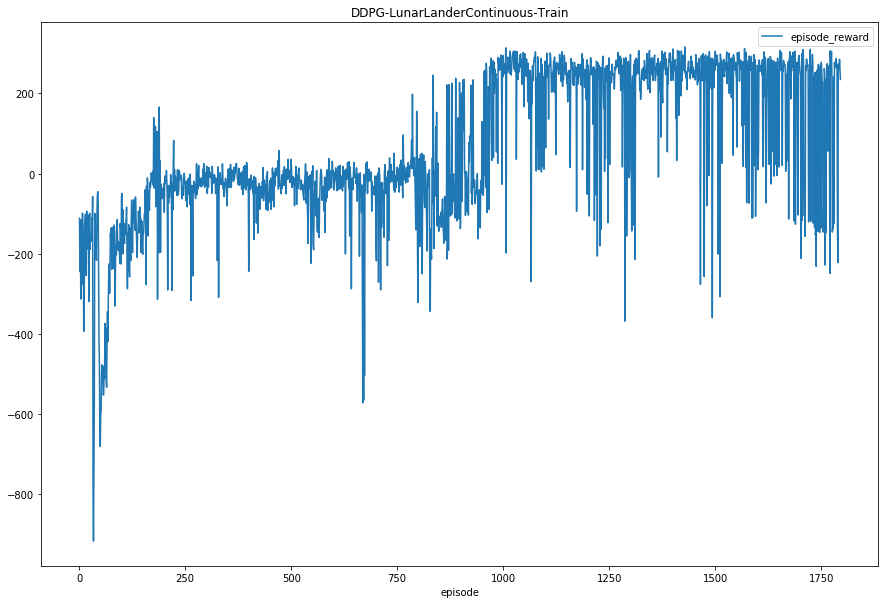

In [20]:
analyze_df.set_index(['episode'])[['episode_reward']].plot()
plt.title('DDPG-LunarLanderContinuous-Train')
plt.savefig(results_save_path+'train_rewards.png', dpi=400, bbox_inches='tight')

In [21]:
test_df = pd.read_csv(results_save_path+'ddpg_{}_results_test.csv'.format(ENV_NAME))
test_df['Unnamed: 0'] +=1
test_df.columns = ['episode', 'episode_reward', 'nb_steps']

In [22]:
test_df.columns

Index(['episode', 'episode_reward', 'nb_steps'], dtype='object')

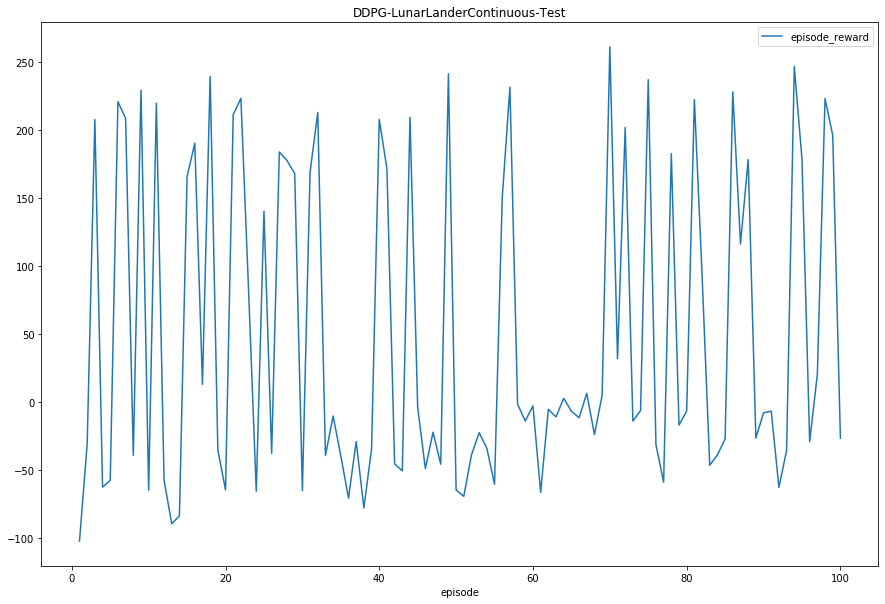

In [24]:
test_df.set_index(['episode'])[['episode_reward']].plot()
plt.title('DDPG-LunarLanderContinuous-Test')
plt.savefig(results_save_path+'test_rewards.png', dpi=400, bbox_inches='tight')